In [4]:
import numpy as np
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

import statmorph
from photutils.segmentation import detect_threshold, detect_sources
from statmorph.utils.image_diagnostics import make_figure
import utils.data
import utils.plots as plots

# Galaxy Toy model test

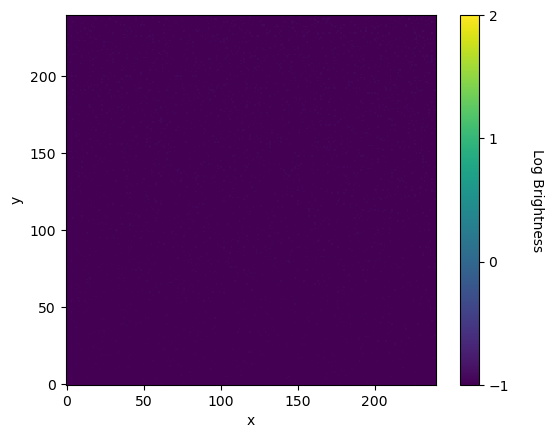

In [ ]:
x, y = np.meshgrid(np.arange(2048), np.arange(2048))

mod = models.Sersic2D(amplitude=1, r_eff=300, n=5, x_0=1024, y_0=1024,
               ellip=0.5, theta=0)
img = mod(x, y)
img += 0.1*np.random.random(size=img.shape)
log_img = np.log10(img)

fig, ax = plt.subplots()
im = ax.imshow(log_img, origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Statmorph fit

In [8]:
center = (len(log_img[1])//2, len(log_img[0])//2)
mask = utils.data.circular_mask(image=img, image_center=center,
                                radius=1024)
morph = statmorph.source_morphology(image=img, segmap=mask, gain=2.25)

In [9]:
print("n = ", morph[0].sersic_n)
print("rhalf = ", morph[0].rhalf_ellip)
print("ellipticity = ", morph[0].ellipticity_asymmetry)

n =  7.915840306473606
rhalf =  226.1806757477987
ellipticity =  0.20792540452003605


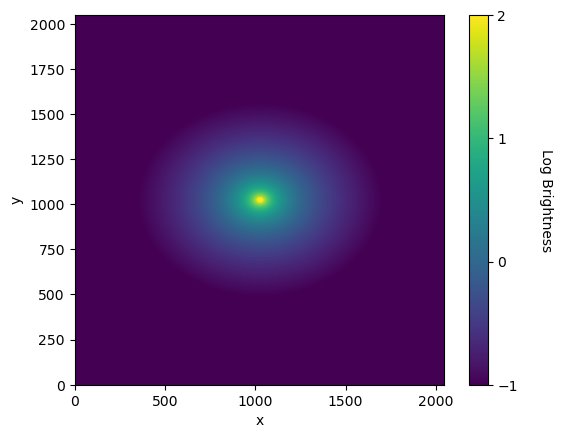

In [ ]:
sm_mod = models.Sersic2D(amplitude=1, r_eff=226.1806757477987, 
                         n=7.915840306473606, x_0=1024, y_0=1024, 
                         ellip=0.20792540452003605, theta=0)
sm_img = sm_mod(x, y)
fig, ax = plt.subplots()
im = ax.imshow(np.log10(sm_img), origin='lower', interpolation='nearest',
               vmin=-1, vmax=2)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

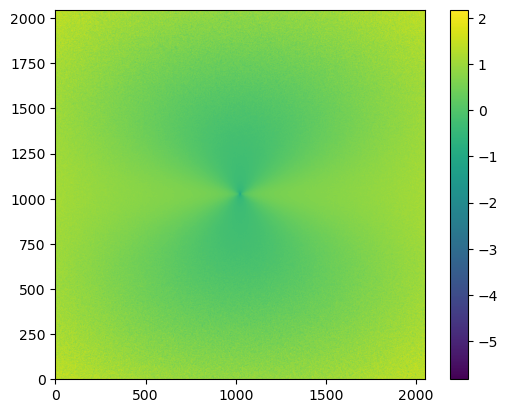

In [17]:
res = np.log(img/sm_img)
plt.imshow(res, origin='lower')
plt.colorbar()

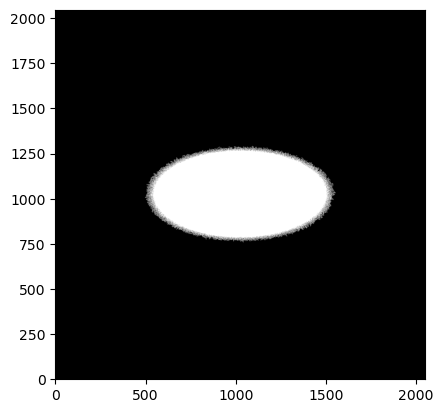

In [18]:
segmap = utils.data.segmentation_map(img, npixels=100)
plt.imshow(segmap, origin='lower', cmap='gray')

In [19]:
morph = statmorph.source_morphology(image=img, segmap=segmap, gain=2.25)

In [6]:
print("n = ", morph[0].sersic_n)
print("rhalf = ", morph[0].rhalf_ellip)
print("ellipticity = ", morph[0].ellipticity_asymmetry)

n =  7.914837808194805
rhalf =  259.46273530712153
ellipticity =  0.49982814917092633


### Astropy fit

In [29]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=15.0, n=1.0,
    x_0=50.0, y_0=50.0, ellip=0.1, theta=0.0
)

fitter = fitting.LevMarLSQFitter()          # uses old scipy method
best_fit = fitter(fit_model, x, y, img, maxiter=1000)
flags = {1: "Success",
         2: "Success",
         3: "Success",
         4: "Success",
         5: "Fail"}
print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Message: {fitter.fit_info['message']}")
print(f"Fit: {flags[fitter.fit_info['ierr']]}")

Fit n: 0.1751801219630313
Fit r_eff: 2.1209477761116045
Fit ellip: 0.16629149396109838
Message: Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Fit: Success


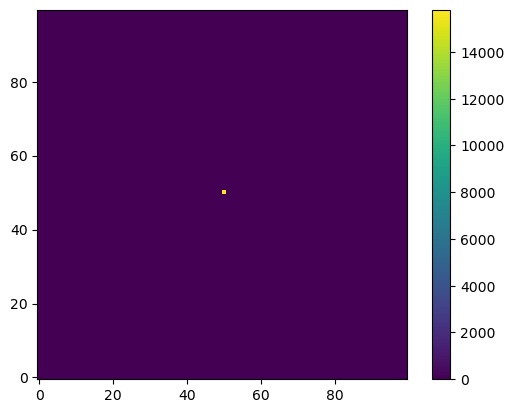

In [119]:
x, y = np.meshgrid(np.arange(100), np.arange(100))
fit_mod = models.Sersic2D(best_fit.parameters)
fit_img = fit_model(x, y)
res = img - fit_img
plt.imshow(res, origin='lower')
plt.colorbar()

In [120]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=15.0, n=1.0,
    x_0=50.0, y_0=50.0, ellip=0.1, theta=0.0
)

fitter = fitting.LMLSQFitter()              # new, up-to-date scipy methods
best_fit = fitter(fit_model, x, y, img, maxiter=10000)

print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Status: {fitter.fit_info['status']}")
print(f"Success: {fitter.fit_info['success']}")
print(f"Message: {fitter.fit_info['message']}")

Fit n: 7.03597616567687
Fit r_eff: 14.848361160205512
Fit ellip: 0.7064022293636665
Status: 3
Success: True
Message: `xtol` termination condition is satisfied.


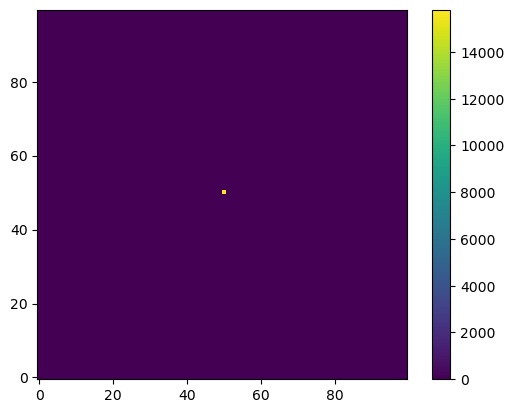

In [121]:
x, y = np.meshgrid(np.arange(100), np.arange(100))
fit_mod = models.Sersic2D(best_fit.parameters)
fit_img = fit_model(x, y)
res = img - fit_img
plt.imshow(res, origin='lower')
plt.colorbar()

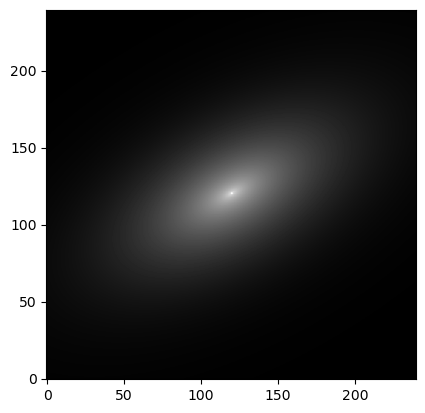

In [51]:
ny, nx = 240, 240
x, y = np.meshgrid(np.arange(240), np.arange(240))
sersic_model = models.Sersic2D(
    amplitude=1, r_eff=20, n=2.5, x_0=120, y_0=120,
    ellip=0.5, theta=0.5)
image = sersic_model(x, y)
plt.imshow(image, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))

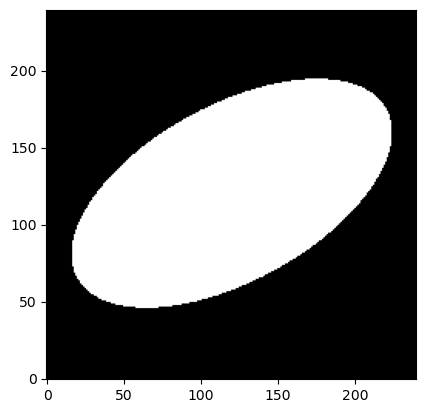

In [52]:
threshold = detect_threshold(image, 1.5)
npixels = 5  # minimum number of connected pixels
segmap = detect_sources(image, threshold, npixels)
plt.imshow(segmap, origin='lower', cmap='gray')

In [53]:
source_morphs = statmorph.source_morphology(
    image, segmap, gain=2.25)

In [54]:
morph = source_morphs[0]
print("n = ", morph.sersic_n)
print("rhalf = ", morph.rhalf_ellip)
print("ellipticity = ", morph.ellipticity_asymmetry)

n =  2.4999999967463182
rhalf =  19.793397475130188
ellipticity =  0.5000408772824801


In [61]:
help(statmorph.source_morphology)

Help on function source_morphology in module statmorph.statmorph:

source_morphology(image, segmap, **kwargs)
    Calculate the morphological parameters of all sources in ``image``
    as labeled by ``segmap``.

    Parameters
    ----------
    image : array-like
        A 2D image containing the sources of interest.
        The image must already be background-subtracted.
    segmap : array-like (int) or `photutils.segmentation.SegmentationImage`
        A 2D segmentation map where different sources are
        labeled with different positive integer values.
        A value of zero is reserved for the background.

    Other parameters
    ----------------
    kwargs : `~statmorph.SourceMorphology` properties.

    Returns
    -------
    sources_morph : list
        A list of `SourceMorphology` objects, one for each
        source. The morphological parameters can be accessed
        as attributes or keys.

    See Also
    --------
    SourceMorphology : Class to measure morphologic

In [59]:
center = (len(image[1])//2, len(image[0])//2)
mask = utils.data.circular_mask(image=img, image_center=center,
                                radius=120)
morph = statmorph.source_morphology(image=img, segmap=mask, gain=2.25)

In [60]:
print("n = ", morph[0].sersic_n)
print("rhalf = ", morph[0].rhalf_ellip)
print("ellipticity = ", morph[0].ellipticity_asymmetry)

n =  4.619168913375033
rhalf =  88.67282931995354
ellipticity =  0.00546417038767355


In [58]:
fit_model = models.Sersic2D(
    amplitude=1.0, r_eff=15.0, n=2.0,
    x_0=120, y_0=120, ellip=0.1, theta=0.0
)

fitter = fitting.LevMarLSQFitter()    
best_fit = fitter(fit_model, x, y, image, maxiter=500)

print(f"Fit n: {best_fit.n.value}")
print(f"Fit r_eff: {best_fit.r_eff.value}")
print(f"Fit ellip: {best_fit.ellip.value}")
print(f"Message: {fitter.fit_info['message']}")

Fit n: 2.8326374516845587
Fit r_eff: 22.871516549687726
Fit ellip: 0.5000331288773933
Message: The relative error between two consecutive iterates is at most 0.000000
